In [48]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import requests
#!pip install opencage
from opencage.geocoder import OpenCageGeocode
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

In [49]:
df_sao = pd.read_csv('saopaulo_crimes.csv')

In [50]:
df_sao.head()

,id,bairro,created_at,descricao,endereco,id.1,ip_address_origin,latitude,longitude,registrou_bo,...,Estepe,MP4 ou Ipod,Móveis,Notebook,Outros,Relógio,Som,Tablet,Tv,time
0,49787,Butantã,2015-06-16 23:34:01.000,"5 bandidos, armas, entraram em casa e vasculha...","Avenida Trona Constanzo, 177, Butantã",49787,NaN,-23.580973,-46.719192,True,...,NaN,True,NaN,True,NaN,NaN,True,True,True,2010-12-20 20:30:00.000
1,10679,Itaquera,2013-09-11 18:26:31.819,"Meu caso foi para o Pequenas Causas, ganhamos ...","Avenida José Pinheiro Borges, 450-876 - Itaque...",10679,187.11.1.51,-23.540105,-46.462872,True,...,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,2012-01-11 14:00:00.000
2,10682,Itaquera,2013-09-11 18:42:07.858,"Meu caso foi para o Pequenas Causas, ganhamos ...",Rua Corínthians - Itaquera - Shopping Metrô It...,10682,189.19.160.82,-23.541765,-46.469562,True,...,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,2012-01-11 14:00:00.000
3,6166,Morumbi,2013-08-20 11:56:52.717,"Estava parada no semáforo, o bandido veio e es...","Rua Pasquale Gallupi, 347 - Morumbi, São Paulo...",6166,199.67.140.46,-23.611693,-46.725935,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-11 18:20:00.000
4,6521,Alto de Pinheiros,2013-08-20 17:41:21.569,Arrombaram o porta malas do meu carro e levara...,"Avenida Professor Fonseca Rodrigues, 1655 - Al...",6521,187.92.158.154,-23.544564,-46.721567,True,...,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,2012-01-11 08:15:00.000


In [51]:
df_sao.shape

(12899, 36)

In [52]:
df_sao.bairro.value_counts()

São Paulo                              630
Consolação                             345
Vila Mariana                           339
Bela Vista                             323
Pinheiros                              240
                                      ... 
Rua Itza                                 1
Rua Curuçá                               1
Rua José Maria Lisboa                    1
Parque Agrinco                           1
Avenida Conselheiro Rodrigues Alves      1
Name: bairro, Length: 1577, dtype: int64

In [53]:
df_sao = df_sao[df_sao["bairro"]!='ヴィーラ・アベセ']

In [54]:
df_sao = df_sao[df_sao["bairro"]!='エルメリノ・マタラーゾ']

In [55]:
df_sao['bairro'].str.lower()

0                    butantã
1                   itaquera
2                   itaquera
3                    morumbi
4          alto de pinheiros
                ...         
12894    jardim das camelias
12895        jardim paulista
12896      vila joao ramalho
12897             campo belo
12898              pinheiros
Name: bairro, Length: 12897, dtype: object

In [56]:
df_sao.bairro.value_counts()

São Paulo                              630
Consolação                             345
Vila Mariana                           339
Bela Vista                             323
Pinheiros                              240
                                      ... 
Rua Itza                                 1
Rua Curuçá                               1
Rua José Maria Lisboa                    1
Parque Agrinco                           1
Avenida Conselheiro Rodrigues Alves      1
Name: bairro, Length: 1575, dtype: int64

In [57]:
df_sao.columns

Index(['id', 'bairro', 'created_at', 'descricao', 'endereco', 'id.1',
       'ip_address_origin', 'latitude', 'longitude', 'registrou_bo', 'sexo',
       'tipo_assalto_id', 'titulo', 'uri', 'user_id', 'valor_prejuizo',
       'Bicicleta', 'Bolsa ou Mochila', 'Carteira', 'Cartão de Crédito',
       'Celular', 'Computador', 'DVD', 'Dinheiro', 'Documentos',
       'Equipamento de Som', 'Estepe', 'MP4 ou Ipod', 'Móveis', 'Notebook',
       'Outros', 'Relógio', 'Som', 'Tablet', 'Tv', 'time'],
      dtype='object')

In [58]:
df_sao.drop(['id.1','ip_address_origin'], axis =1, inplace = True)

In [59]:
df_sao.tipo_assalto_id.value_counts()

2     5801
1     2980
9     1042
3      965
5      799
11     524
6      369
4      179
10     126
8       75
7       37
Name: tipo_assalto_id, dtype: int64

In [60]:
df_sao.bairro.unique()

array(['Butantã', 'Itaquera', 'Morumbi', ..., 'Rua Carlos Sampaio',
       'Vila Maracana', 'Vila Joao Ramalho'], dtype=object)

In [61]:
column_names = ['Neighborhood', 'Borough'] 
sao_neigh_bor = pd.DataFrame(columns=column_names)

In [62]:
sao_neigh_bor['Neighborhood'] = df_sao['bairro'].unique()

In [63]:
## Creating : https://es.wikipedia.org/wiki/Subdivisiones_de_la_Ciudad_de_S%C3%A3o_Paulo ##
neigh_bor_dict = {'Sé':'Central', 'Bela Vista':'Central', 'Bom Retiro':'Central', 'Cambuci':'Central', 'Consolação':'Central','Liberdade':'Central','República':'Central','Santa Cecília':'Central',
                  'Ermelino Matarazzo':'East1','Ponte Rasa':'East1', 'Itaquera':'East1', 'Cidade Líder':'East1','José Bonifácio':'East1','Parque do Carmo':'East1','Penha':'East1','Cangaíba':'East1','Vila Matilde':'East1','Artur Alvim':'East1','São Mateus':'East1','São Rafael':'East1','Iguatemi':'East1',
                  'Cidade Tiradentes':'East2', 'Itaim Paulista':'East2','Vila Curuçá':'East2','Guaianases':'East2','Lajeado':'East2','São Miguel Paulista':'East2','Vila Jacuí':'East2','Jardim Helena':'East2',
                  'Aricanduva':'SouthEast', 'Vila Formosa':'SouthEast','Carrão':'SouthEast','Ipiranga':'SouthEast','Cursino':'SouthEast','Sacomã':'SouthEast','Mooca':'SouthEast','Tatuapé':'SouthEast','Pari':'SouthEast','Brás':'SouthEast','Belém':'SouthEast','Água Rasa':'SouthEast','Vila Prudente':'SouthEast','São Lucas':'SouthEast','Sapopemba':'SouthEast',
                  'Butantã':'West','Morumbi':'West','Vila Sônia':'West','Río Pequeno':'West','Raposo Tavares':'West','Lapa':'West','Barra Funda':'West','Perdizes':'West','Vila Leopoldina':'West','Jaguara':'West','Jaguaré':'West','Pinheiros':'West','Alto de Pinheiros':'West','Jardim Paulista':'West','Itaim Bibi':'West',
                  'Casa Verde':'NorthEst','Cachoeirinha':'NorthEst','Limão':'NorthEst','Jaçanã':'NorthEst','Tremembé':'NorthEst','Santana':'NorthEst','Tucuruvi':'NorthEst','Mandaqui':'NorthEst','Vila Maria':'NorthEst','Vila Guilherme':'NorthEst','Vila Medeiros':'NorthEst',
                  'Freguesia do Ó':'NorthWest','Brasilândia':'NorthWest','Perus':'NorthWest','Anhangüera':'NorthWest','Pirituba':'NorthWest','Jaraguá':'NorthWest','São Domingos':'NorthWest',
                  'Jabaquara':'SouthCentral','Santo Amaro':'SouthCentral','Campo Belo':'SouthCentral','Campo Grande':'SouthCentral','Vila Mariana':'SouthCentral','Moema':'SouthCentral','Saúde':'SouthCentral',
                  'Socorro':'South','Cidade Dutra':'South','Grajaú':'South','Campo Limpo':'South','Capão Redondo':'South','Vila Andrade':'South','Cidade Ademar':'South','Pedreira':'South','Jardim Ângela':'South','Jardim São Luís':'South','Parelheiros':'South','Marsilac':'South'}

In [64]:
for row, neigh in zip(neigh_bor_dict, sao_neigh_bor['Neighborhood']):
  sao_neigh_bor.loc[sao_neigh_bor.Neighborhood == row, 'Borough'] = neigh_bor_dict.get(row)

In [65]:
sao_neigh_bor.dropna(inplace=True)

In [66]:
print("Total Neighbourhood Count",len(sao_neigh_bor['Neighborhood']),"Borough Count",len(sao_neigh_bor['Borough'].unique()))

Total Neighbourhood Count 93 Borough Count 9


In [67]:
sao_neigh_bor.head()

,Neighborhood,Borough
0,Butantã,West
1,Itaquera,East1
2,Morumbi,West
3,Alto de Pinheiros,West
5,Vila Mariana,SouthCentral


In [68]:
df_sao.rename(index=str,columns={"bairro":"Neighborhood"}, inplace = True)

In [69]:
df_sao.columns

Index(['id', 'Neighborhood', 'created_at', 'descricao', 'endereco', 'latitude',
       'longitude', 'registrou_bo', 'sexo', 'tipo_assalto_id', 'titulo', 'uri',
       'user_id', 'valor_prejuizo', 'Bicicleta', 'Bolsa ou Mochila',
       'Carteira', 'Cartão de Crédito', 'Celular', 'Computador', 'DVD',
       'Dinheiro', 'Documentos', 'Equipamento de Som', 'Estepe', 'MP4 ou Ipod',
       'Móveis', 'Notebook', 'Outros', 'Relógio', 'Som', 'Tablet', 'Tv',
       'time'],
      dtype='object')

In [70]:
df_sao.drop(['Bicicleta', 'Bolsa ou Mochila',
       'Carteira', 'Cartão de Crédito', 'Celular', 'Computador', 'DVD',
       'Dinheiro', 'Documentos', 'Equipamento de Som', 'Estepe', 'MP4 ou Ipod',
       'Móveis', 'Notebook', 'Outros', 'Relógio', 'Som', 'Tablet', 'Tv'], axis =1, inplace = True)

In [71]:
df_sao.head()

,id,Neighborhood,created_at,descricao,endereco,latitude,longitude,registrou_bo,sexo,tipo_assalto_id,titulo,uri,user_id,valor_prejuizo,time
0,49787,Butantã,2015-06-16 23:34:01.000,"5 bandidos, armas, entraram em casa e vasculha...","Avenida Trona Constanzo, 177, Butantã",-23.580973,-46.719192,True,0,6,Entraram na minha casa e ficaram por 2h30,/denuncias/a71rZe-entraram-na-minha-casa-e-fic...,NaN,60.0,2010-12-20 20:30:00.000
1,10679,Itaquera,2013-09-11 18:26:31.819,"Meu caso foi para o Pequenas Causas, ganhamos ...","Avenida José Pinheiro Borges, 450-876 - Itaque...",-23.540105,-46.462872,True,1,1,Rádio do Carro Furtado,/denuncias/z6nRrz-radio-do-carro-furtado,NaN,0.0,2012-01-11 14:00:00.000
2,10682,Itaquera,2013-09-11 18:42:07.858,"Meu caso foi para o Pequenas Causas, ganhamos ...",Rua Corínthians - Itaquera - Shopping Metrô It...,-23.541765,-46.469562,True,1,1,Rádio do carro furtado no estacionamento PAGO ...,/denuncias/V9lNKa-radio-do-carro-furtado-no-es...,NaN,300.0,2012-01-11 14:00:00.000
3,6166,Morumbi,2013-08-20 11:56:52.717,"Estava parada no semáforo, o bandido veio e es...","Rua Pasquale Gallupi, 347 - Morumbi, São Paulo...",-23.611693,-46.725935,True,0,5,Quebraram a janela do meu carro,/denuncias/a4NB1e-quebraram-a-janela-do-meu-carro,NaN,2500.0,2012-01-11 18:20:00.000
4,6521,Alto de Pinheiros,2013-08-20 17:41:21.569,Arrombaram o porta malas do meu carro e levara...,"Avenida Professor Fonseca Rodrigues, 1655 - Al...",-23.544564,-46.721567,True,1,1,Arrombaram meu carro que estava no estacioname...,/denuncias/zD1lJa-arrombaram-meu-carro-que-est...,NaN,9999.0,2012-01-11 08:15:00.000


In [72]:
df_sao.drop(['descricao','registrou_bo','sexo','titulo','time','uri',
       'user_id'], axis =1, inplace = True)

In [73]:
sao_boroughs_crime = pd.merge(df_sao,sao_neigh_bor, on='Neighborhood')

sao_boroughs_crime.head()

,id,Neighborhood,created_at,endereco,latitude,longitude,tipo_assalto_id,valor_prejuizo,Borough
0,49787,Butantã,2015-06-16 23:34:01.000,"Avenida Trona Constanzo, 177, Butantã",-23.580973,-46.719192,6,60.0,West
1,14160,Butantã,2013-12-02 14:17:28.941,"Rua Júlia Della Nina, 6-28 - Butantã, São Paul...",-23.573288,-46.730640,9,0.0,West
2,6644,Butantã,2013-08-20 20:23:04.234,"Praça do Oceanográfico, 200-232 - Butantã, São...",-23.560333,-46.731334,1,100.0,West
3,10572,Butantã,2013-09-09 19:56:01.999,"Avenida Corifeu de Azevedo Marques, 3138-3198 ...",-23.569339,-46.741414,1,500.0,West
4,7653,Butantã,2013-08-22 14:05:18.130,"Rua Mário Maglio, 75 - Butantã, São Paulo, 055...",-23.576977,-46.715921,2,500.0,West


In [74]:
sao_boroughs_crime.dropna(inplace=True)
sao_boroughs_crime['Borough'].value_counts()

Central         1177
West            1098
SouthCentral     823
SouthEast        765
NorthEst         304
South            294
East1            207
NorthWest         86
East2             82
Name: Borough, dtype: int64

In [75]:
# METODOLOGIA: 
# EDA : visualizar los crimenes en los diferentes boroughs de sao paulo, para asi encontrar el mas safe y 
# normalizar los neghborhood en ese borough. con esto encontraermos las 10 most common venues par each neighboorhood
# MODELAMIENTO : encontraremos el correcto neighbothood en un borough, vamos a usar clustering de k-means
# que es una forma unsupervised de machine learning. vamos a uasr kmean para agrupar la existing venues que nos
# ayudaran a tomar una decision.

In [76]:
pd.pivot_table(sao_boroughs_crime, index = 'Borough', values = 'valor_prejuizo')

,valor_prejuizo
Borough,
Central,1688.258359
East1,1947.813710
East2,1961.046951
NorthEst,3517.630230
NorthWest,2753.627907
South,2231.686735
SouthCentral,2330.712333
SouthEast,3136.865031
West,2357.506284


In [77]:
sao_neigh_graph = pd.pivot_table(sao_boroughs_crime, index='Neighborhood', aggfunc='size', fill_value=0)
sao_neigh_graph

Neighborhood
Alto de Pinheiros     41
Aricanduva            15
Artur Alvim           13
Barra Funda           85
Bela Vista           323
                    ... 
Vila Matilde          14
Vila Medeiros         12
Vila Prudente         69
Vila Sônia            41
Água Rasa             16
Length: 93, dtype: int64

In [78]:
###### NEIGHS WITH HIGHEST CRIMES ########
sao_neigh_graph.sort_values(ascending = False, axis = 0, inplace = True )
sao_neigh_graph

sao_neigh_graph_top5 = sao_neigh_graph.iloc[1:6]
sao_neigh_graph_top5

Neighborhood
Vila Mariana    339
Bela Vista      323
Pinheiros       240
Ipiranga        210
Butantã         173
dtype: int64

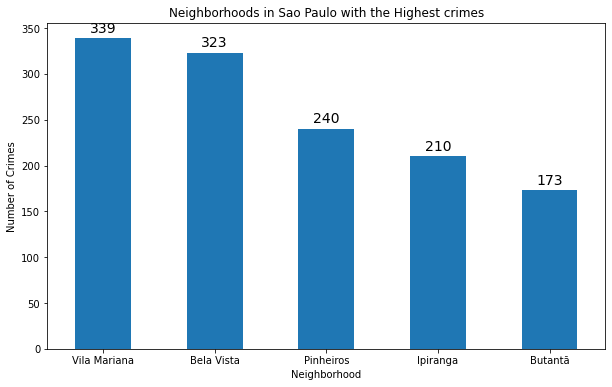

In [79]:
ax = sao_neigh_graph_top5.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighborhood')
ax.set_title('Neighborhoods in Sao Paulo with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

In [80]:
# NEIGHS WITH LOWEST CRIMES ##

sao_neigh_graph_low5 = sao_neigh_graph.tail(5)
sao_neigh_graph_low5

Neighborhood
José Bonifácio    3
Parelheiros       3
Iguatemi          1
Jardim Ângela     1
Guaianases        1
dtype: int64

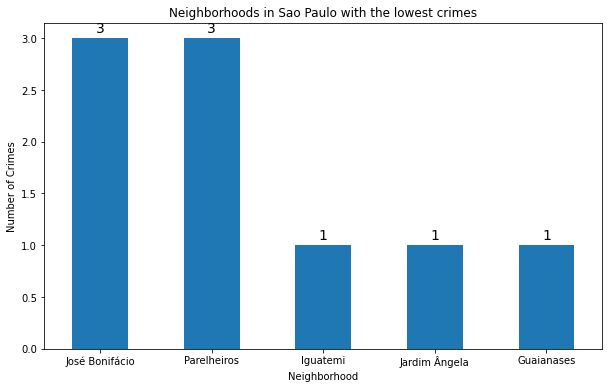

In [81]:
ax = sao_neigh_graph_low5.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighborhood')
ax.set_title('Neighborhoods in Sao Paulo with the lowest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

In [82]:
sao_bor_graph = pd.pivot_table(sao_boroughs_crime, index='Borough', aggfunc='size', fill_value=0)
sao_bor_graph

Borough
Central         1177
East1            207
East2             82
NorthEst         304
NorthWest         86
South            294
SouthCentral     823
SouthEast        765
West            1098
dtype: int64

In [83]:
###### BOROUGHS WITH HIGHEST CRIMES ########
sao_bor_graph.sort_values(ascending = False, axis = 0, inplace = True )
sao_bor_graph

sao_bor_graph_top5 = sao_bor_graph.iloc[1:6]
sao_bor_graph_top5

Borough
West            1098
SouthCentral     823
SouthEast        765
NorthEst         304
South            294
dtype: int64

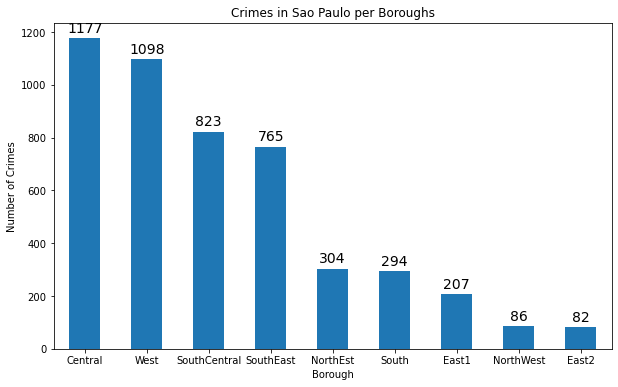

In [84]:
ax = sao_bor_graph.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Crimes in Sao Paulo per Boroughs')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

In [85]:
# NorthWest and East2, has the less crimes in Sao Paulo, so we can choose any of these#

In [86]:
## Dataframe for East2 Borough ##

sao_east2_neigh = sao_boroughs_crime[sao_boroughs_crime['Borough'] == 'East2']
sao_east2_neigh.reset_index(inplace=True, drop=True)

In [87]:
sao_east2_neigh.head()

,id,Neighborhood,created_at,endereco,latitude,longitude,tipo_assalto_id,valor_prejuizo,Borough
0,59311,Itaim Paulista,2016-02-12 01:01:42.094,"Rua Bartolomeu Bernardi, 1–67, Itaim Paulista",-23.495400,-46.394537,2,1.4,East2
1,37816,Itaim Paulista,2014-11-06 01:18:34.458,"Rua Manuel Barbalho de Lima, 435-765 - Itaim P...",-23.498690,-46.406894,2,500.0,East2
2,41868,Itaim Paulista,2014-12-02 04:54:47.854,"Rua Valsa dos Casais, 28 - Itaim Paulista, São...",-23.507854,-46.379026,1,200.0,East2
3,65699,Itaim Paulista,2016-06-21 13:36:45.617,"Rua Engenheiro Álvaro Cunha, 158–202, Itaim Pa...",-23.506380,-46.369380,9,20.0,East2
4,36916,Itaim Paulista,2014-11-02 18:33:47.152,"Rua Tibúrcio de Sousa, 1561 - Itaim Paulista, ...",-23.510472,-46.394512,2,300.9,East2


In [88]:
print('Number of Neighborhoods in East2 Borough: ', len(sao_east2_neigh['Neighborhood'].unique()))
sao_east2_neigh['Neighborhood'].unique()

Number of Neighborhoods in East2 Borough:  8


array(['Itaim Paulista', 'Vila Jacuí', 'Jardim Helena', 'Vila Curuçá',
       'Lajeado', 'São Miguel Paulista', 'Cidade Tiradentes',
       'Guaianases'], dtype=object)

In [89]:
## Dataframe for NorthWest Borough ##
sao_nw_neigh = sao_boroughs_crime
sao_nw_neigh = sao_nw_neigh[sao_nw_neigh['Borough'] == 'NorthWest']
sao_nw_neigh.reset_index(inplace=True, drop=True)
sao_nw_neigh.head()

,id,Neighborhood,created_at,endereco,latitude,longitude,tipo_assalto_id,valor_prejuizo,Borough
0,47305,Perus,2015-03-17 01:28:27.924,"Viaduto Dona Mora Guimarães, Perus",-23.404777,-46.750556,3,700.0,NorthWest
1,75471,Perus,2016-12-10 22:00:20.577,"Rua Antônio de Pádua Dias, 274, Perus",-23.402082,-46.748613,9,30.0,NorthWest
2,78342,Perus,2017-03-04 00:53:29.739,"R. Estevan Ribeiro Resende, 570 - Perus, São P...",-23.400424,-46.745665,9,0.0,NorthWest
3,81405,Perus,2017-05-27 23:01:14.090,"R. Mogeiro, 381 - Perus, São Paulo - SP, Brasil",-23.407226,-46.758708,3,1900.0,NorthWest
4,75398,Perus,2016-12-09 04:13:41.097,"Rua Estevan Ribeiro Resende, 2-64, Perus",-23.407756,-46.747862,3,0.0,NorthWest


In [90]:
print('Number of Neighborhoods in NorthWest Borough: ', len(sao_nw_neigh['Neighborhood'].unique()))
sao_nw_neigh['Neighborhood'].unique()

Number of Neighborhoods in NorthWest Borough:  6


array(['Perus', 'São Domingos', 'Freguesia do Ó', 'Jaraguá',
       'Brasilândia', 'Pirituba'], dtype=object)

In [91]:
# FOR EAST 2#

Latitude = []
Longitude = []
Borough = []
Neighborhood = sao_east2_neigh['Neighborhood'].unique()

key = '87691387c2464a1793c47f6912182806'
geocoder = OpenCageGeocode(key)

for i in range(len(Neighborhood)):
    address = '{}, Sao Paulo, Brasil'.format(Neighborhood[i])
    location = geocoder.geocode(address)
    Latitude.append(location[0]['geometry']['lat'])
    Longitude.append(location[0]['geometry']['lng'])
    Borough.append('East2')
print(Latitude, Longitude)

print('The geograpical coordinate of Sao Paulo are {}, {}.'.format(latitude, longitude))

[-23.5017648, -23.500294, -23.4822835, -23.510151, -23.5362478, -23.5026845, -23.5824973, -23.555665] [-46.3996091, -46.4587174, -46.4234102, -46.4178928, -46.4100218, -46.4383287, -46.4092065, -46.4093288]


NameError: name 'latitude' is not defined

In [92]:
# FOR North West#

Latitude = []
Longitude = []
Borough = []
Neighborhoodnw = sao_nw_neigh['Neighborhood'].unique()

key = '87691387c2464a1793c47f6912182806'
geocoder = OpenCageGeocode(key)

for i in range(len(Neighborhoodnw)):
    address = '{}, Sao Paulo, Brasil'.format(Neighborhoodnw[i])
    location = geocoder.geocode(address)
    Latitude.append(location[0]['geometry']['lat'])
    Longitude.append(location[0]['geometry']['lng'])
    Borough.append('NorthWest')
print(Latitude, Longitude)

#print('The geograpical coordinate of Sao Paulo are {}, {}.'.format(latitude, longitude))

[-23.4084915, -23.4937631, -23.4874636, -23.446592, -23.4482715, -23.485533] [-46.7436432, -46.7455806, -46.6951317, -46.7361775, -46.6902693, -46.7219385]


In [93]:
frames = [sao_nw_neigh, sao_east2_neigh]
sao_geo = pd.concat(frames)
sao_geo.head()

,id,Neighborhood,created_at,endereco,latitude,longitude,tipo_assalto_id,valor_prejuizo,Borough
0,47305,Perus,2015-03-17 01:28:27.924,"Viaduto Dona Mora Guimarães, Perus",-23.404777,-46.750556,3,700.0,NorthWest
1,75471,Perus,2016-12-10 22:00:20.577,"Rua Antônio de Pádua Dias, 274, Perus",-23.402082,-46.748613,9,30.0,NorthWest
2,78342,Perus,2017-03-04 00:53:29.739,"R. Estevan Ribeiro Resende, 570 - Perus, São P...",-23.400424,-46.745665,9,0.0,NorthWest
3,81405,Perus,2017-05-27 23:01:14.090,"R. Mogeiro, 381 - Perus, São Paulo - SP, Brasil",-23.407226,-46.758708,3,1900.0,NorthWest
4,75398,Perus,2016-12-09 04:13:41.097,"Rua Estevan Ribeiro Resende, 2-64, Perus",-23.407756,-46.747862,3,0.0,NorthWest


In [94]:
sao_geo.Borough.value_counts()

NorthWest    86
East2        82
Name: Borough, dtype: int64

In [95]:
# Finding Sao Paulo Cords #

address = 'Sao Paulo, Brasil'

location = geocoder.geocode(address)
latitude = location[0]['geometry']['lat']
longitude = location[0]['geometry']['lng']

print('The geograpical coordinate of Sao Paulo are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sao Paulo are -23.5506507, -46.6333824.


In [96]:
# Folium to plot Sao Paulo with Neighborhoods as Markers #

sao_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(sao_geo['latitude'], sao_geo['longitude'], sao_geo['Borough'], sao_geo['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(sao_map)  
    
sao_map

In [97]:
# Look up for Venues #

CLIENT_ID = 'EVLNNO3KWVCFBPMRLLD5GNBQGIFNVPTVEA1AEDRHHPKW1YYJ' # your Foursquare ID
CLIENT_SECRET = 'WONXNSFY5Q1UWS5N5RFA5NA2MNDFW2GN24XTCIGVYQXHYTVG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EVLNNO3KWVCFBPMRLLD5GNBQGIFNVPTVEA1AEDRHHPKW1YYJ
CLIENT_SECRET:WONXNSFY5Q1UWS5N5RFA5NA2MNDFW2GN24XTCIGVYQXHYTVG


In [98]:
#Generating Venues#

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [102]:
#Generating Venues#

sao_venues = getNearbyVenues(names=sao_geo['Neighborhood'],
                                   latitudes=sao_geo['latitude'],
                                   longitudes=sao_geo['longitude']
                                  )

Perus
Perus
Perus
Perus
Perus
Perus
São Domingos
São Domingos
São Domingos
São Domingos
São Domingos
São Domingos
São Domingos
São Domingos
São Domingos
São Domingos
São Domingos
São Domingos
São Domingos
São Domingos
São Domingos
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Freguesia do Ó
Jaraguá
Jaraguá
Jaraguá
Jaraguá
Jaraguá
Jaraguá
Jaraguá
Jaraguá
Jaraguá
Jaraguá
Jaraguá
Jaraguá
Jaraguá
Jaraguá
Jaraguá
Jaraguá
Jaraguá
Brasilândia
Brasilândia
Brasilândia
Brasilândia
Brasilândia
Brasilândia
Brasilândia
Brasilândia
Brasilândia
Brasilândia
Pirituba
Pirituba
Pirituba
Pirituba
Pirituba
Pirituba
Pirituba
Pirituba
Pirituba
Pirituba
Pirituba
Pirituba
Pirituba
Pirituba
Pirituba
Pirituba
Pirituba
Pirituba
Pirituba
Itaim Paulista
Itaim Paulista
Itaim Paulista
Itaim Paulis

In [103]:
#Data Frame for Venues #

print(sao_venues.shape)
sao_venues.head()

(2130, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Perus,-23.404777,-46.750556,Subway,-23.406594,-46.752787,Sandwich Place
1,Perus,-23.404777,-46.750556,Pastel de Vento,-23.404618,-46.747488,Fast Food Restaurant
2,Perus,-23.404777,-46.750556,Perus Burguers,-23.404837,-46.747196,Burger Joint
3,Perus,-23.404777,-46.750556,Dan Dog,-23.404538,-46.747933,Snack Place
4,Perus,-23.404777,-46.750556,Padaria Nova Perus,-23.406718,-46.752981,Bakery


In [104]:
#Venues per Neigh#

sao_venues.groupby('Neighborhood').count().drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Category','Venue Longitude','Venue Latitude'], axis = 1)

,Venue
Neighborhood,
Brasilândia,137
Cidade Tiradentes,76
Freguesia do Ó,370
Guaianases,5
Itaim Paulista,348
Jaraguá,111
Jardim Helena,160
Lajeado,76
Perus,63


In [105]:
## Modeling ##

# one hot encoding
sao_onehot = pd.get_dummies(sao_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sao_onehot['Neighborhood'] = sao_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sao_onehot.columns[-1]] + list(sao_onehot.columns[:-1])
sao_onehot = sao_onehot[fixed_columns]

sao_onehot.head()

,Neighborhood,Acai House,Accessories Store,American Restaurant,Arcade,Arepa Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,...,Track,Trail,Train Station,Travel Agency,Volleyball Court,Warehouse,Warehouse Store,Water Park,Wings Joint,Women's Store
0,Perus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Perus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Perus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Perus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Perus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
sao_grouped = sao_onehot.groupby('Neighborhood').mean().reset_index()
sao_grouped

,Neighborhood,Acai House,Accessories Store,American Restaurant,Arcade,Arepa Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,...,Track,Trail,Train Station,Travel Agency,Volleyball Court,Warehouse,Warehouse Store,Water Park,Wings Joint,Women's Store
0,Brasilândia,0.000000,0.000000,0.000000,0.000000,0.007299,0.000000,0.007299,0.000000,0.014599,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Cidade Tiradentes,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000
2,Freguesia do Ó,0.005405,0.000000,0.000000,0.000000,0.000000,0.000000,0.013514,0.027027,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Guaianases,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Itaim Paulista,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.002874,0.008621,0.000000,0.002874,0.000000,0.000000,0.000000,0.000000,0.002874
5,Jaraguá,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.027027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027027,0.000000
6,Jardim Helena,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0125,0.000000,0.006250,0.000000,0.000000,0.000000,0.012500,0.000000,0.000000,0.012500
7,Lajeado,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013158,0.000000,0.000000,0.000000
8,Perus,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.015873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Pirituba,0.000000,0.000000,0.000000,0.000000,0.000000,0.012552,0.000000,0.000000,0.004184,...,0.0000,0.004184,0.000000,0.000000,0.000000,0.004184,0.000000,0.020921,0.000000,0.004184


In [107]:
# Top 5 Venues per Neigh #

num_top_venues = 5

for hood in sao_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sao_grouped[sao_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Brasilândia----
                  venue  freq
0                Bakery  0.08
1           Pizza Place  0.07
2  Gym / Fitness Center  0.05
3            Food Truck  0.04
4     Convenience Store  0.04


----Cidade Tiradentes----
               venue  freq
0        Pizza Place  0.11
1             Bakery  0.09
2                Gym  0.08
3        Snack Place  0.08
4  Convenience Store  0.08


----Freguesia do Ó----
                  venue  freq
0                Bakery  0.09
1           Pizza Place  0.08
2              Pharmacy  0.05
3  Gym / Fitness Center  0.04
4  Brazilian Restaurant  0.04


----Guaianases----
            venue  freq
0     Pizza Place   0.4
1      Shoe Store   0.2
2  Farmers Market   0.2
3       Drugstore   0.2
4      Acai House   0.0


----Itaim Paulista----
                  venue  freq
0           Pizza Place  0.09
1                Bakery  0.08
2   Japanese Restaurant  0.06
3          Dessert Shop  0.05
4  Fast Food Restaurant  0.05


----Jaraguá----
                 

In [108]:
#Data Frame for top10 venues for each neigh#

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [109]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sao_grouped['Neighborhood']

for ind in np.arange(sao_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sao_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brasilândia,Bakery,Pizza Place,Gym / Fitness Center,Convenience Store,Food Truck,Gym,Market,Snack Place,Pharmacy,Grocery Store
1,Cidade Tiradentes,Pizza Place,Bakery,Convenience Store,Gym,Snack Place,Gym / Fitness Center,Grocery Store,Pharmacy,Furniture / Home Store,Comfort Food Restaurant
2,Freguesia do Ó,Bakery,Pizza Place,Pharmacy,Gym / Fitness Center,Bar,Brazilian Restaurant,Pet Store,Athletics & Sports,BBQ Joint,Ice Cream Shop
3,Guaianases,Pizza Place,Farmers Market,Shoe Store,Drugstore,Women's Store,Dog Run,Fish Market,Fireworks Store,Fast Food Restaurant,Farm
4,Itaim Paulista,Pizza Place,Bakery,Japanese Restaurant,Dessert Shop,Fast Food Restaurant,Brazilian Restaurant,Food Truck,Flower Shop,Snack Place,Supermarket


In [110]:
# Clustering neighs #

# set number of clusters
kclusters = 5

sao_grouped_clustering = sao_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sao_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 0, 1, 0, 0, 0, 0, 0, 0])

In [113]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sao_merged = sao_geo

# merge toronto_grouped with Vancouver data to add latitude/longitude for each neighborhood
sao_merged = sao_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

sao_merged.head()

ValueError: cannot insert Cluster Labels, already exists

In [112]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sao_merged['latitude'], sao_merged['longitude'], sao_merged['Neighborhood'], sao_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [114]:
# ANALYSIS: Examining Clusters #
# Cluster 1 #
sao_merged.loc[sao_merged['Cluster Labels'] == 0, sao_merged.columns[[1] + list(range(5, sao_merged.shape[1]))]]

,Neighborhood,longitude,tipo_assalto_id,valor_prejuizo,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Perus,-46.750556,3,700.0,NorthWest,0,Bakery,Snack Place,Pizza Place,Burger Joint,Convenience Store,Plaza,Dessert Shop,Fast Food Restaurant,Big Box Store,Steakhouse
1,Perus,-46.748613,9,30.0,NorthWest,0,Bakery,Snack Place,Pizza Place,Burger Joint,Convenience Store,Plaza,Dessert Shop,Fast Food Restaurant,Big Box Store,Steakhouse
2,Perus,-46.745665,9,0.0,NorthWest,0,Bakery,Snack Place,Pizza Place,Burger Joint,Convenience Store,Plaza,Dessert Shop,Fast Food Restaurant,Big Box Store,Steakhouse
3,Perus,-46.758708,3,1900.0,NorthWest,0,Bakery,Snack Place,Pizza Place,Burger Joint,Convenience Store,Plaza,Dessert Shop,Fast Food Restaurant,Big Box Store,Steakhouse
4,Perus,-46.747862,3,0.0,NorthWest,0,Bakery,Snack Place,Pizza Place,Burger Joint,Convenience Store,Plaza,Dessert Shop,Fast Food Restaurant,Big Box Store,Steakhouse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,Lajeado,-46.406548,9,1900.0,East2,0,Brazilian Restaurant,Pizza Place,Bakery,Ice Cream Shop,Gym / Fitness Center,Department Store,Camera Store,Chocolate Shop,Gymnastics Gym,Outlet Mall
62,Lajeado,-46.406548,2,0.0,East2,0,Brazilian Restaurant,Pizza Place,Bakery,Ice Cream Shop,Gym / Fitness Center,Department Store,Camera Store,Chocolate Shop,Gymnastics Gym,Outlet Mall
63,Lajeado,-46.413523,2,4500.0,East2,0,Brazilian Restaurant,Pizza Place,Bakery,Ice Cream Shop,Gym / Fitness Center,Department Store,Camera Store,Chocolate Shop,Gymnastics Gym,Outlet Mall
64,Lajeado,-46.400106,3,2000.0,East2,0,Brazilian Restaurant,Pizza Place,Bakery,Ice Cream Shop,Gym / Fitness Center,Department Store,Camera Store,Chocolate Shop,Gymnastics Gym,Outlet Mall


In [115]:
# Cluster 2 #

sao_merged.loc[sao_merged['Cluster Labels'] == 1, sao_merged.columns[[1] + list(range(5, sao_merged.shape[1]))]]

,Neighborhood,longitude,tipo_assalto_id,valor_prejuizo,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
81,Guaianases,-46.40257,2,0.0,East2,1,Pizza Place,Farmers Market,Shoe Store,Drugstore,Women's Store,Dog Run,Fish Market,Fireworks Store,Fast Food Restaurant,Farm


In [116]:
# Cluster 3 #

sao_merged.loc[sao_merged['Cluster Labels'] == 2, sao_merged.columns[[1] + list(range(5, sao_merged.shape[1]))]]

,Neighborhood,longitude,tipo_assalto_id,valor_prejuizo,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,Vila Curuçá,-46.421931,2,1500.0,East2,2,Brazilian Restaurant,Gym / Fitness Center,Gym,Grocery Store,Bakery,Supermarket,Furniture / Home Store,Farmers Market,Gymnastics Gym,Soccer Field
48,Vila Curuçá,-46.423467,2,7000.0,East2,2,Brazilian Restaurant,Gym / Fitness Center,Gym,Grocery Store,Bakery,Supermarket,Furniture / Home Store,Farmers Market,Gymnastics Gym,Soccer Field
49,Vila Curuçá,-46.402518,1,500.0,East2,2,Brazilian Restaurant,Gym / Fitness Center,Gym,Grocery Store,Bakery,Supermarket,Furniture / Home Store,Farmers Market,Gymnastics Gym,Soccer Field
50,Vila Curuçá,-46.421931,2,1000.0,East2,2,Brazilian Restaurant,Gym / Fitness Center,Gym,Grocery Store,Bakery,Supermarket,Furniture / Home Store,Farmers Market,Gymnastics Gym,Soccer Field
51,Vila Curuçá,-46.420018,1,0.0,East2,2,Brazilian Restaurant,Gym / Fitness Center,Gym,Grocery Store,Bakery,Supermarket,Furniture / Home Store,Farmers Market,Gymnastics Gym,Soccer Field
52,Vila Curuçá,-46.407576,2,450.0,East2,2,Brazilian Restaurant,Gym / Fitness Center,Gym,Grocery Store,Bakery,Supermarket,Furniture / Home Store,Farmers Market,Gymnastics Gym,Soccer Field
53,Vila Curuçá,-46.424683,2,400.0,East2,2,Brazilian Restaurant,Gym / Fitness Center,Gym,Grocery Store,Bakery,Supermarket,Furniture / Home Store,Farmers Market,Gymnastics Gym,Soccer Field
54,Vila Curuçá,-46.402551,2,1200.0,East2,2,Brazilian Restaurant,Gym / Fitness Center,Gym,Grocery Store,Bakery,Supermarket,Furniture / Home Store,Farmers Market,Gymnastics Gym,Soccer Field
55,Vila Curuçá,-46.419401,2,554.0,East2,2,Brazilian Restaurant,Gym / Fitness Center,Gym,Grocery Store,Bakery,Supermarket,Furniture / Home Store,Farmers Market,Gymnastics Gym,Soccer Field
56,Vila Curuçá,-46.429167,2,800.0,East2,2,Brazilian Restaurant,Gym / Fitness Center,Gym,Grocery Store,Bakery,Supermarket,Furniture / Home Store,Farmers Market,Gymnastics Gym,Soccer Field


In [117]:
# Cluster 4 #

sao_merged.loc[sao_merged['Cluster Labels'] == 3, sao_merged.columns[[1] + list(range(5, sao_merged.shape[1]))]]

,Neighborhood,longitude,tipo_assalto_id,valor_prejuizo,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
71,Cidade Tiradentes,-46.407596,9,30.0,East2,3,Pizza Place,Bakery,Convenience Store,Gym,Snack Place,Gym / Fitness Center,Grocery Store,Pharmacy,Furniture / Home Store,Comfort Food Restaurant
72,Cidade Tiradentes,-46.396026,11,250.0,East2,3,Pizza Place,Bakery,Convenience Store,Gym,Snack Place,Gym / Fitness Center,Grocery Store,Pharmacy,Furniture / Home Store,Comfort Food Restaurant
73,Cidade Tiradentes,-46.412882,3,400.0,East2,3,Pizza Place,Bakery,Convenience Store,Gym,Snack Place,Gym / Fitness Center,Grocery Store,Pharmacy,Furniture / Home Store,Comfort Food Restaurant
74,Cidade Tiradentes,-46.408782,1,0.0,East2,3,Pizza Place,Bakery,Convenience Store,Gym,Snack Place,Gym / Fitness Center,Grocery Store,Pharmacy,Furniture / Home Store,Comfort Food Restaurant
75,Cidade Tiradentes,-46.401176,2,85.0,East2,3,Pizza Place,Bakery,Convenience Store,Gym,Snack Place,Gym / Fitness Center,Grocery Store,Pharmacy,Furniture / Home Store,Comfort Food Restaurant
76,Cidade Tiradentes,-46.414403,2,350.0,East2,3,Pizza Place,Bakery,Convenience Store,Gym,Snack Place,Gym / Fitness Center,Grocery Store,Pharmacy,Furniture / Home Store,Comfort Food Restaurant
77,Cidade Tiradentes,-46.406829,6,3000.0,East2,3,Pizza Place,Bakery,Convenience Store,Gym,Snack Place,Gym / Fitness Center,Grocery Store,Pharmacy,Furniture / Home Store,Comfort Food Restaurant
78,Cidade Tiradentes,-46.402828,2,400.0,East2,3,Pizza Place,Bakery,Convenience Store,Gym,Snack Place,Gym / Fitness Center,Grocery Store,Pharmacy,Furniture / Home Store,Comfort Food Restaurant
79,Cidade Tiradentes,-46.408650,11,0.1,East2,3,Pizza Place,Bakery,Convenience Store,Gym,Snack Place,Gym / Fitness Center,Grocery Store,Pharmacy,Furniture / Home Store,Comfort Food Restaurant
80,Cidade Tiradentes,-46.403863,2,10000.0,East2,3,Pizza Place,Bakery,Convenience Store,Gym,Snack Place,Gym / Fitness Center,Grocery Store,Pharmacy,Furniture / Home Store,Comfort Food Restaurant


In [118]:
# Cluster 5 #

sao_merged.loc[sao_merged['Cluster Labels'] == 4, sao_merged.columns[[1] + list(range(5, sao_merged.shape[1]))]]

,Neighborhood,longitude,tipo_assalto_id,valor_prejuizo,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Vila Jacuí,-46.448207,2,55.0,East2,4,Bakery,Bar,Gym,Pizza Place,Brazilian Restaurant,Ice Cream Shop,College Cafeteria,Burger Joint,Recording Studio,Chocolate Shop
27,Vila Jacuí,-46.454452,2,400.0,East2,4,Bakery,Bar,Gym,Pizza Place,Brazilian Restaurant,Ice Cream Shop,College Cafeteria,Burger Joint,Recording Studio,Chocolate Shop
28,Vila Jacuí,-46.465270,9,50.0,East2,4,Bakery,Bar,Gym,Pizza Place,Brazilian Restaurant,Ice Cream Shop,College Cafeteria,Burger Joint,Recording Studio,Chocolate Shop
29,Vila Jacuí,-46.453218,1,0.0,East2,4,Bakery,Bar,Gym,Pizza Place,Brazilian Restaurant,Ice Cream Shop,College Cafeteria,Burger Joint,Recording Studio,Chocolate Shop
30,Vila Jacuí,-46.453751,5,0.0,East2,4,Bakery,Bar,Gym,Pizza Place,Brazilian Restaurant,Ice Cream Shop,College Cafeteria,Burger Joint,Recording Studio,Chocolate Shop
31,Vila Jacuí,-46.455241,1,4500.0,East2,4,Bakery,Bar,Gym,Pizza Place,Brazilian Restaurant,Ice Cream Shop,College Cafeteria,Burger Joint,Recording Studio,Chocolate Shop
32,Vila Jacuí,-46.450910,2,600.0,East2,4,Bakery,Bar,Gym,Pizza Place,Brazilian Restaurant,Ice Cream Shop,College Cafeteria,Burger Joint,Recording Studio,Chocolate Shop
33,Vila Jacuí,-46.467024,11,0.0,East2,4,Bakery,Bar,Gym,Pizza Place,Brazilian Restaurant,Ice Cream Shop,College Cafeteria,Burger Joint,Recording Studio,Chocolate Shop


# Results and Discussion

**As I mentioned the objective of the problem was to help stakeholders to identify the safest borough in Sao Paulo, and an good neighborhood within the borough to set up a commercial store.** 

**This has been achieved by first making use of Sao Paulo crime data to identify a safe borough with variety of neighborhoods for any type of business. After selecting the borough it was imperative to choose the right neighborhood where the comercial stores were not among venues in a close proximity to each other. We made this by grouping the neighborhoods into clusters to assist the stakeholders by providing them with relevant data about venues and safety of a given neighborhood.**

# Conslusion

**We used the crime data to take a look of crimes in all neighborhoods of Sao Paulo, Brasil and later categorized them into different boroughs, this helped us grouping the neighborhoods into boroughs and choose the safest borough first. We achieve this picking the two safest boroughs in Sao Paulo and then checking the most common venues for both. Finally we use K-means to cluster this two boroughs and this way we can take a look for choosing the best neighborhood for any type of comercial business**

**Once we confirmed the borough the number of neighborhoods for consideration also comes down, we further shortlist the neighborhoods based on the common venues, to choose a neighborhood which best suits the business problem.**